In [1]:
from operator import index
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import math
import logging
import numpy as np
import seaborn as sns
from pycparser.c_ast import Break

import index_definition
import index_utils as ai
from confidence_index import get_index_cut_by_time
from train_online_model import predict, generate_live_match_data
import warnings
import common
import dill
import confidence_index as ci

# 忽略所有警告
warnings.filterwarnings("ignore")
# logging.basicConfig(
#     level=logging.INFO,  
#     format='%(asctime)s [简记] %(message)s',  # 去除非必要字段
#     handlers=[
#         logging.StreamHandler(), 
#         logging.FileHandler('data_analysis.log') 
#     ]
# )

data = pd.read_csv("Linhac24-25_Sportlogiq.csv")
data['inopponentarea'] = data.apply(common.puck_location, axis=1)
gameids = data['gameid'].unique()

In [2]:
 #探究信心指数对比赛结果的影响

gameids = gameids[0:4]

team_feature_df = get_index_cut_by_time(data, gameids, index_definition.CONFIDENCE_INDEX, 120, tfrom=0, to=3600)
max_cols = 2  #每行最多显示2张
num_plots = len(gameids) * 2
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
sns.set_theme(style="dark")

for i in range(len(gameids)):
    gameid = gameids[i]
    j = i * 2 if i > 0 else 0
    winner = common.get_winner(data, gameid)
    winnerid = winner[0]
    loserid = winner[1]
    winner_df = team_feature_df[(team_feature_df['gameid'] == gameid) & (team_feature_df['teamid'] == winnerid)]
    winner_goal = winner_df[winner_df['goal'] == 1]['elapsed_sec'].values
    loser_df = team_feature_df[(team_feature_df['gameid'] == gameid) & (team_feature_df['teamid'] == loserid)]
    loser_goal = loser_df[loser_df['goal'] == 1]['elapsed_sec'].values
    feature_names = ['accuracy_reception_succ', 'accuracy_pass_succ', 'efficient_block_succ', 'body_check']
    colors = sns.color_palette("bright", n_colors=len(feature_names))
    ax = plt.subplot(rows, cols, j + 1)
    ax0 = plt.subplot(rows, cols, j + 2)
    for c, (f, color) in enumerate(zip(feature_names, colors)):
        sns.lineplot( x=list(winner_df['elapsed_sec']),y=list(winner_df[f]), color=color, label=f, ax=ax)
        ax.set_title('Game:' + str(gameid) + 'WinnerTeamid:' + str(winnerid))
        # sns.lineplot( x=list(loser_df['elapsed_sec']), y=list(loser_df[f]),color=color, label=f, ax=ax0)
        # ax0.set_title('Game:' + str(gameid) + 'LoseTeamid:' + str(loserid))
        for goal_time in winner_goal:
            ax.vlines(x=goal_time, ymin=0, ymax=ax.get_ylim()[1], color='green', linestyles='-')
        # for goal_time in loser_goal:
        #     ax0.vlines(x=goal_time, ymin=0, ymax=ax0.get_ylim()[1], color='green', linestyles='-')
    for c, (f, color) in enumerate(zip(feature_names, colors)):
        # sns.lineplot( x=list(winner_df['elapsed_sec']),y=list(winner_df[f]), color=color, label=f, ax=ax)
        # ax.set_title('Game:' + str(gameid) + 'WinnerTeamid:' + str(winnerid))
        sns.lineplot( x=list(loser_df['elapsed_sec']), y=list(loser_df[f]),color=color, label=f, ax=ax0)
        ax0.set_title('Game:' + str(gameid) + 'LoseTeamid:' + str(loserid))
        # for goal_time in winner_goal:
        #     ax.vlines(x=goal_time, ymin=0, ymax=ax.get_ylim()[1], color='green', linestyles='-')
        for goal_time in loser_goal:
            ax0.vlines(x=goal_time, ymin=0, ymax=ax0.get_ylim()[1], color='green', linestyles='-')
plt.tight_layout()
plt.legend()
plt.show()

🚀 Processing: 150it [00:01, 92.33it/s]             ?, ?it/s]


KeyError: 'goal'

<Figure size 1500x1200 with 0 Axes>

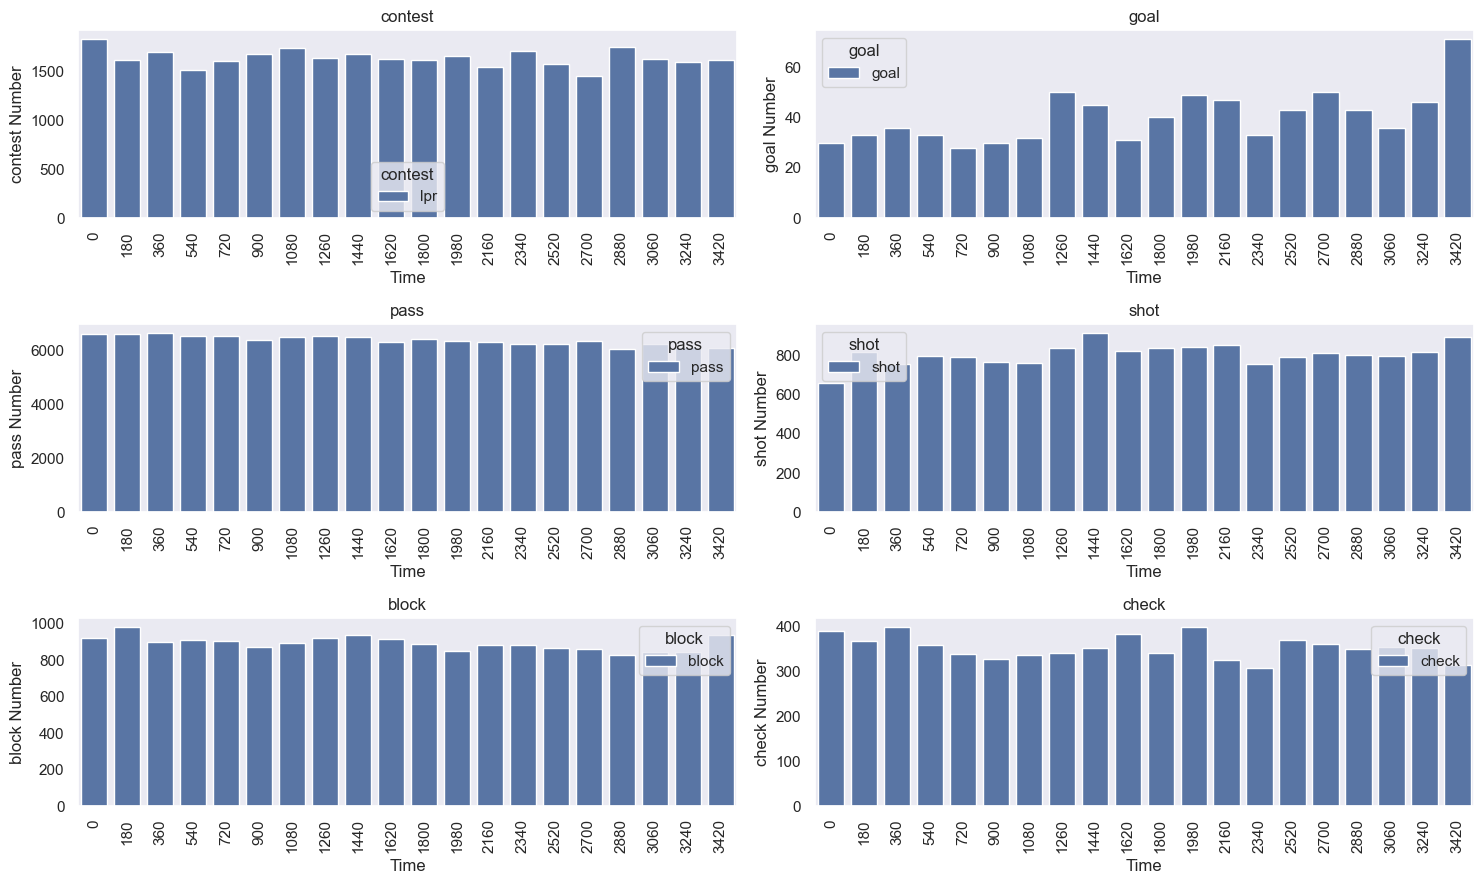

In [4]:
#所有比赛的整体数据分析
events = {**index_definition.CONTEST,**index_definition.GOAL, **index_definition.PASS, **index_definition.SHOT, **index_definition.BLOCK,**index_definition.CHECK, }
max_cols = 2  #每行最多显示2张
num_plots = len(events) 
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
normal_time_df = data[(data['compiledgametime'] <= 3600)]
for index, (event_name, event) in enumerate(events.items()):
    ax = plt.subplot(rows, cols, index+1)
    condition = normal_time_df.eval(event)
    event_df = normal_time_df[condition]
    bin_inter = 180
    bins = list(np.arange(0, 3600, bin_inter))
    bins.append(3600)
    labels = bins[0:20]
    event_df['cut'] = pd.cut(event_df['compiledgametime'], bins=bins, labels=labels)
    sns.countplot(x='cut', hue='eventname', data=event_df,ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(event_name)
    ax.set_xlabel('Time')
    ax.set_ylabel(event_name + ' Number')
    ax.legend(title=event_name)


plt.tight_layout()
# 显示图表
plt.show()

In [5]:
#比赛0到540秒,即前9分钟,相比较与其他时间段进球的队伍，首先进球队伍的胜率非常低，只有48%，输掉比赛的概率有41%，
# 其他时间段内普遍在60%以上，其中在后半场开场后一段时间内，进球队伍胜率最高，达到了70%以上
start_time = 0
end_time =  600
total_games = 0
first_goal_win_teams = 0
first_goal_home_win_teams = 0
first_goal_win_tie_teams =0
first_goal_lost_teams = 0
special_time_df =  data[(data['compiledgametime'] <= end_time) & (data['compiledgametime'] >= start_time) & (data['eventname'] == 'goal')]
grouped = special_time_df.groupby('gameid')
for gameid, gamedata in grouped:
    total_games += 1
    winner = common.get_winner(data, gameid)
    home_team_id = common.get_home_team_id(data, gameid)
    goal_team = gamedata['teaminpossession'].unique()
    #如果这个时间段两个队伍都进球了，只计算第一个进球的队伍
    if len(goal_team) == 2:
        goal_team = gamedata.iloc[0]['teaminpossession']
    else:
        goal_team =gamedata['teaminpossession'].unique()[0]
    if goal_team == winner[0]: #至少比赛是平局
        first_goal_win_tie_teams += 1
        if  winner[2] is True: #比赛不是平局
            first_goal_win_teams += 1
            if winner[0] == home_team_id:
                first_goal_home_win_teams += 1
    else:
        first_goal_lost_teams += 1
print('总比赛场次:', total_games,',至少平局场次:', first_goal_win_tie_teams, ',赢下比赛场次:', first_goal_win_teams, '输掉比赛场次:', first_goal_lost_teams)
print('至少平局的概率:', first_goal_win_tie_teams / total_games)
print('赢下比赛的概率:', first_goal_win_teams / total_games)
print('是主队且赢下比赛的概率:', first_goal_home_win_teams / total_games)
print('输掉比赛的概率:', first_goal_lost_teams / total_games)


总比赛场次: 84 ,至少平局场次: 49 ,赢下比赛场次: 41 输掉比赛场次: 35
至少平局的概率: 0.5833333333333334
赢下比赛的概率: 0.4880952380952381
是主队且赢下比赛的概率: 0.36904761904761907
输掉比赛的概率: 0.4166666666666667


#探究控所有比赛主队和客队的球率
#发现主队在开场9分钟内控球率最高，客队在开场9分钟内控球率最低，结合上面的分析，可以看出主队在开场9分钟内控球率高，如果进球,赢球的概率却最低.



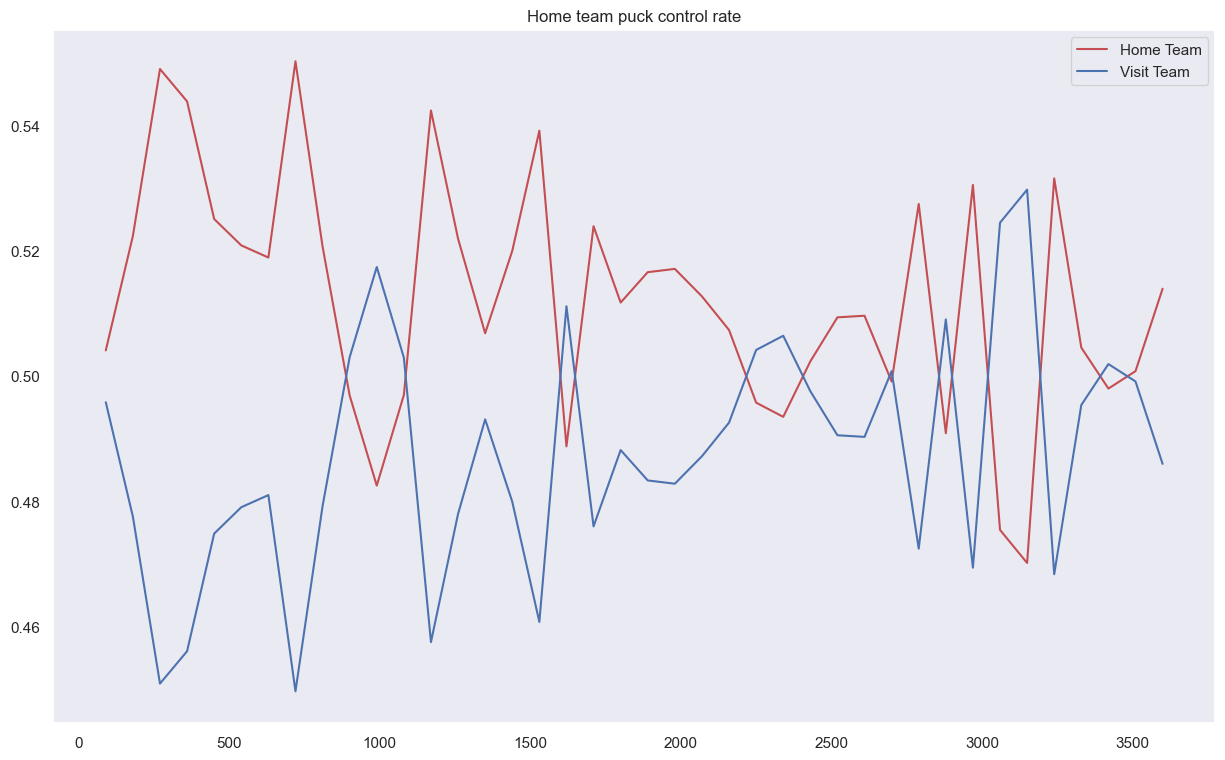

In [3]:
#探究控所有比赛主队和客队的球率
#发现主队在开场9分钟内控球率最高，客队在开场9分钟内控球率最低，结合上面的分析，可以看出主队在开场9分钟内控球率高，如果进球,赢球的概率却最低.
bin_inter = 90
plt.figure(figsize=(10, 3))
bin_number = int(3600 / bin_inter)
unique_gameids = data['gameid'].unique()
gameids = unique_gameids[0:156]
home_total_control_times = [0] * bin_number
visit_total_control_times = [0] * bin_number
home_total_control_rates = [0] * bin_number
visit_total_control_rates = [0] * bin_number
game_first_period_control_rate= {}
game_all_period_control_times= {}
#按队伍计算每个时间段的控球率
game_total_control_rates = {}
for gameid in gameids:
    gamedata = data[(data['gameid'] == gameid)]
    game_home_total_control_times = [0] * bin_number
    game_visit_total_control_times = [0] * bin_number
    bins = list(np.arange(0, 3600, bin_inter))
    bins.append(3600)
    for i in range(len(bins)):
        if i + 1 == len(bins):
            game_first_period_control_rate[gameid] = game_home_total_control_times[0] / (
                        game_home_total_control_times[0] + game_visit_total_control_times[0])
            game_total_control_rates[gameid] = sum(game_home_total_control_times) / (
                        sum(game_home_total_control_times) + sum(game_visit_total_control_times))
            game_all_period_control_times[gameid]= [game_home_total_control_times, game_visit_total_control_times]
            break
        tfrom = bins[i]
        to = bins[i + 1]
        home_control_rate, visit_control_rate, home_possession_time, visit_possession_time = common.get_control_rate0(
            data, gameid, tfrom, to)
        home_total_control_times[i] = sum(home_possession_time) + home_total_control_times[i]
        visit_total_control_times[i] = sum(visit_possession_time) + visit_total_control_times[i]
        home_total_control_rates[i] = home_total_control_times[i] / (
                    home_total_control_times[i] + visit_total_control_times[i])
        visit_total_control_rates[i] = visit_total_control_times[i] / (
                    home_total_control_times[i] + visit_total_control_times[i])
        game_home_total_control_times[i] = sum(home_possession_time) 
        game_visit_total_control_times[i] = sum(visit_possession_time) 
plt.title('Home team puck control rate')
sns.lineplot(x=bins[1:], y=home_total_control_rates, color='r', label='Home Team')
sns.lineplot(x=bins[1:], y=visit_total_control_rates, color='b', label='Visit Team')
plt.legend()
plt.show()


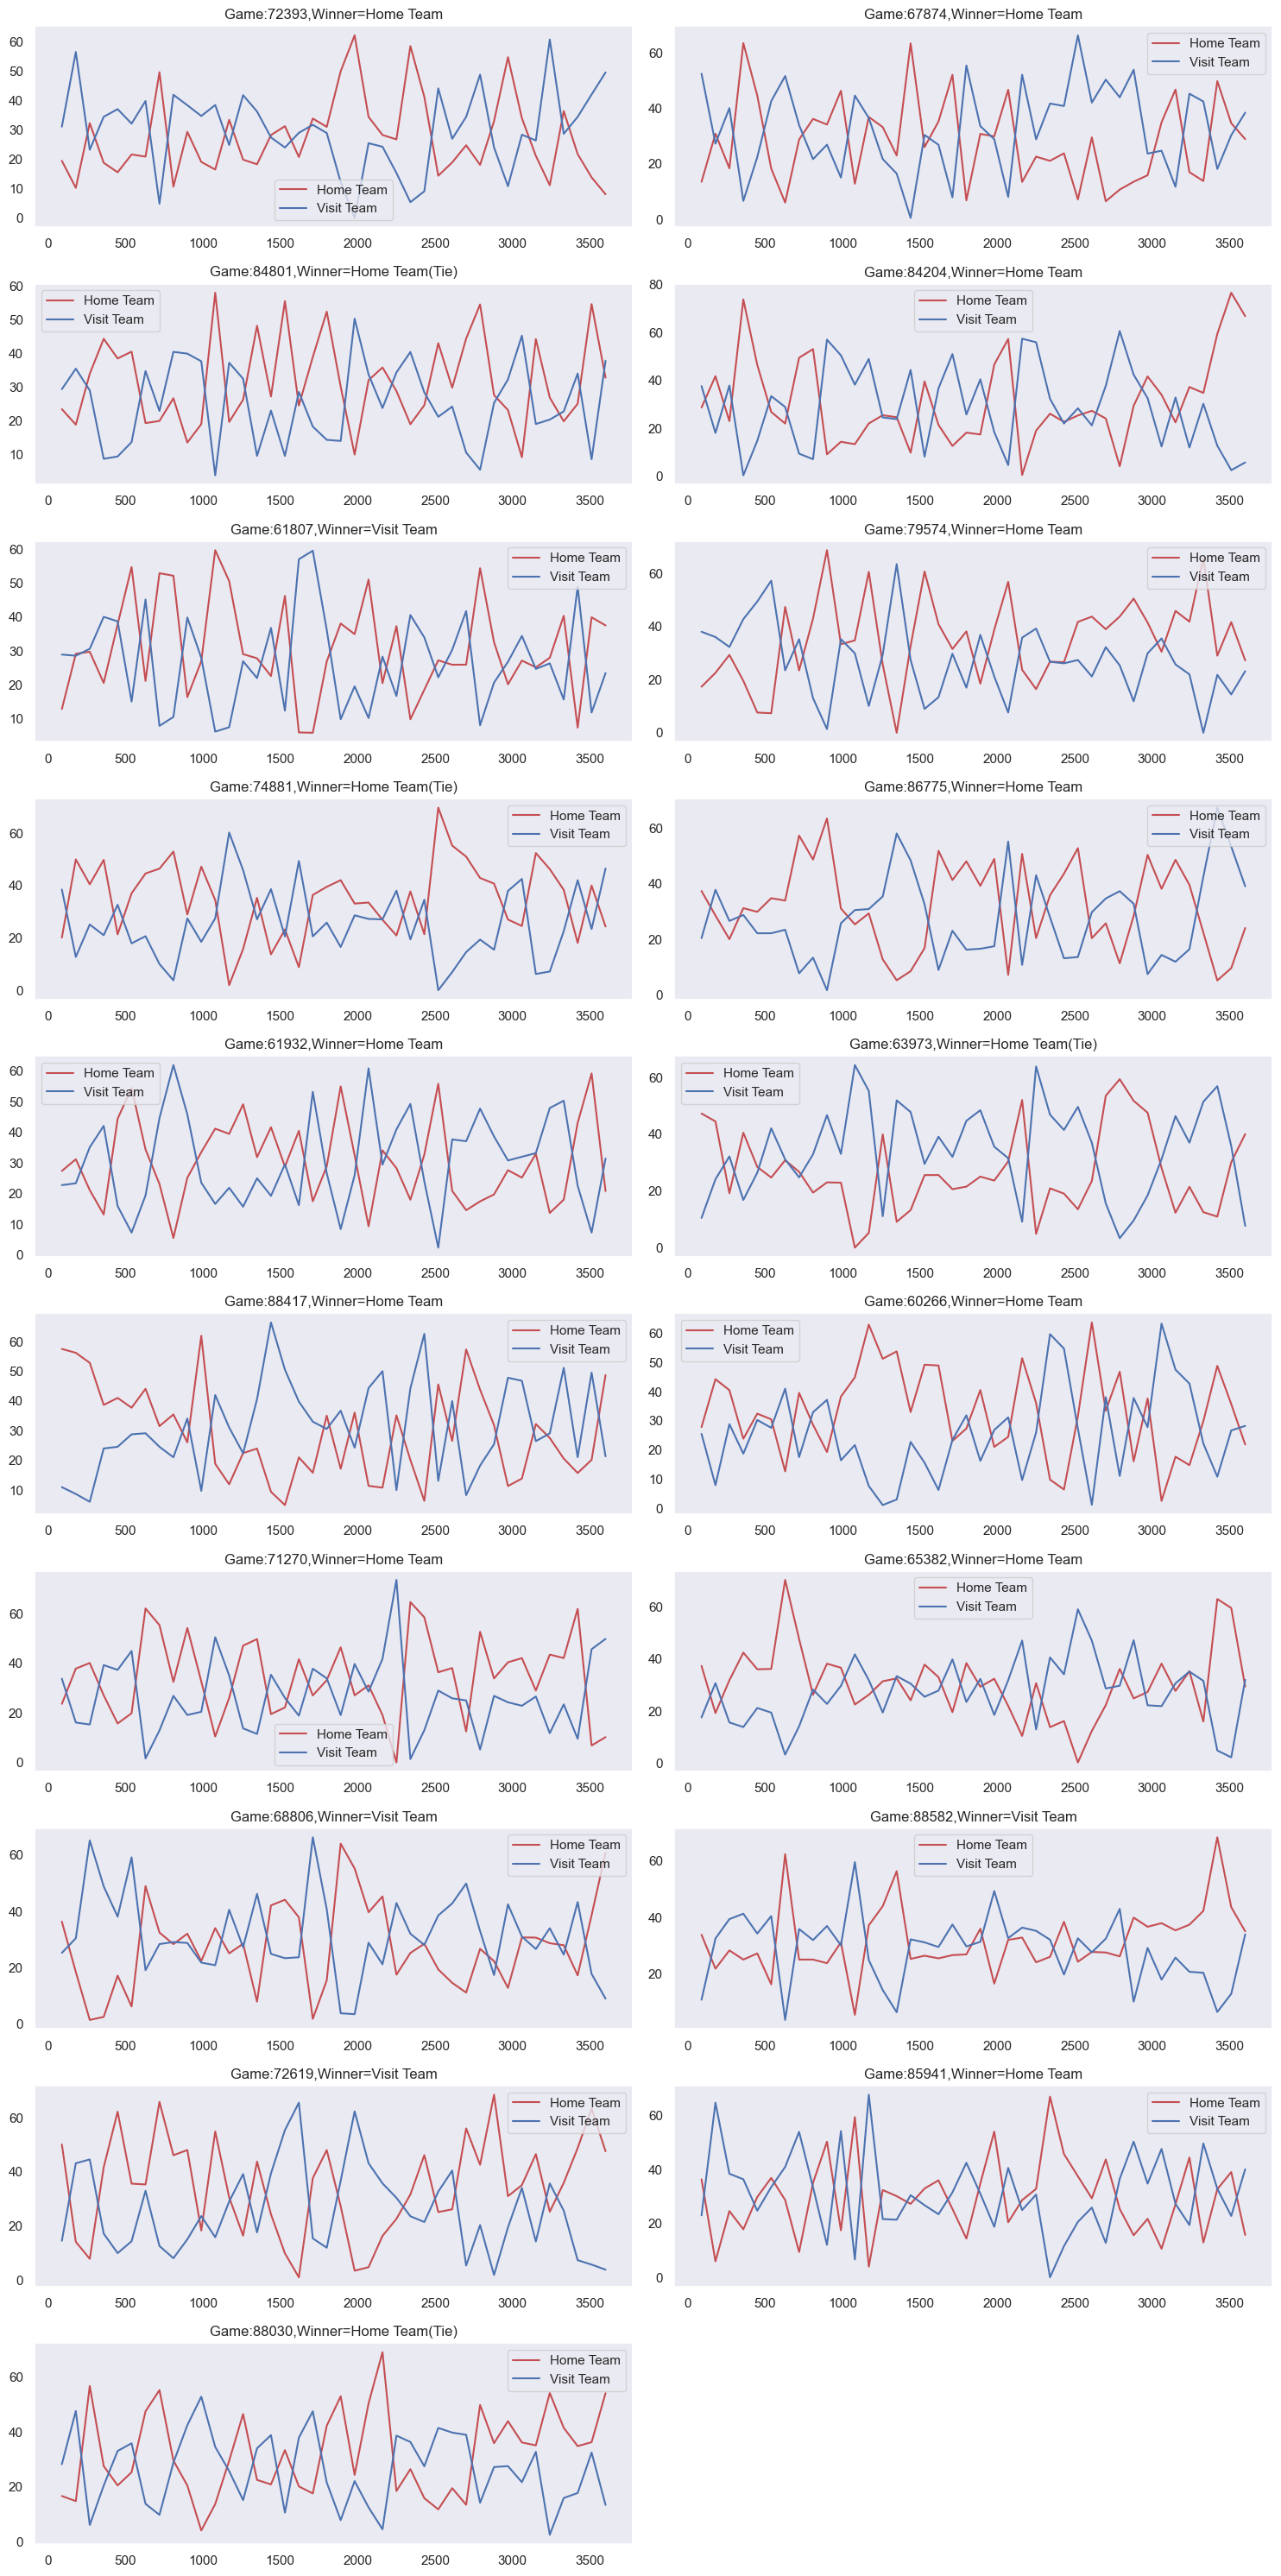

In [7]:
# 控球率与比赛结果的关系，按时间和比赛计算

max_cols = 2  #每行最多显示2张
num_plots = 20
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
sns.set_theme(style="dark")
for index, (gameid, game_control_times) in enumerate(game_all_period_control_times.items()):
    if index == num_plots - 1 : break
    home_control_times = game_control_times[0]
    visit_control_times = game_control_times[1]
    winner = common.get_winner(data, gameid)
    home_team_id = common.get_home_team_id(data,gameid)
    winnerid = winner[0]
    loserid = winner[1]
    ax = plt.subplot(rows, cols, index + 1)
    sns.lineplot(x=bins[1:], y=home_control_times, color='r', label='Home Team', ax=ax)
    title = 'Game:' + str(gameid) + ',Winner=Home Team'  if winnerid == home_team_id else 'Game:' + str(gameid) + ',Winner=Visit Team'
    if winner[2] is False:
        ax.set_title('Game:' + str(gameid) + ',Winner=Home Team(Tie)')
    else:
        ax.set_title(title)
    # ax0 = plt.subplot(rows, cols, index * 2 + 2)
    sns.lineplot(x=bins[1:], y=visit_control_times, color='b', label='Visit Team', ax=ax)
    # ax.set_title('Game:' + str(gameid) + 'LoseTeamid:' + str(loserid))
plt.legend()
plt.tight_layout()
# 显示图表
plt.show()



In [5]:

#所以，我们有个猜想，第一节耗能最多的球队，反而最后会输掉比赛
#耗能的event数量太多，不一一分析，这里只分析一个event，即body_check
#看看第一节Body check和胜率的关系
# body_check_df =  data[(data['compiledgametime'] <= end_time) & (data['compiledgametime'] >= start_time) & (data['eventname'] == 'check') & (data['type'] == 'body')]
# max_cols = 2  #每行最多显示2张
# num_plots = 50
# rows = (num_plots + max_cols - 1) // max_cols
# cols = min(max_cols, num_plots)
# plt.figure(figsize=(15, rows * 3))
# sns.set_theme(style="dark")
grouped = data.groupby('gameid')
gameids = unique_gameids.tolist()
detail_df = ci.get_index_cut_by_time(data, gameids, {**index_definition.BODY, **index_definition.CONTEST},
                                    time_interval=180)
#计算前9分钟body的次数，以及比赛的结果
detail_df = detail_df[(detail_df['elapsed_sec'] <= 1200) & (detail_df['elapsed_sec'] >= 540)]
game_check_dict = {}
for gameid in gameids:
    game_df = detail_df[detail_df['gameid'] == gameid]
    team_ids = game_df['teamid'].unique().tolist()
    
    game_check_dict[gameid] = {}
    for teamid in team_ids:
        team_df = game_df[game_df['teamid'] == teamid]
        body_event_sum = team_df['contest'].sum()
        game_check_dict[gameid][teamid] = body_event_sum
more_body_win = 0
less_body_win = 0
tie = 0
other = 0
for gameid, value in game_check_dict.items():
    winner = common.get_winner(data, gameid)
    home_team_id = common.get_home_team_id(data, gameid)
    teamids = list(value.keys())
    body_sums = list(value.values())
    if body_sums[0] > body_sums[1]:
        if winner[0] == teamids[0] and winner[2] is True:
            more_body_win += 1
        elif winner[0] == teamids[1] and winner[2] is True:
            less_body_win += 1
        elif winner[2] is False:
            tie += 1
    elif body_sums[0] < body_sums[1]:
        if winner[0] == teamids[0] and winner[2] is True:
            less_body_win += 1
        elif winner[0] == teamids[1] and winner[2] is True:
            more_body_win += 1
        elif winner[2] is False:
            tie += 1
print("其他情况数量:" + str(other))
print("平局数量:" + str(tie))
print("第一节更少的body check的队伍赢得比赛数量:" + str(less_body_win))
print("第一节更多的body check的队伍赢得比赛数量:" + str(more_body_win))
print("第一节更少的body check的队伍赢得比赛的概率是：" + str(less_body_win / len(gameids)))
print("第一节更多的body check的队伍赢得比赛的概率是：" + str(more_body_win / len(gameids)))



🚀 Processing: 7674it [00:18, 425.70it/s]                        0.41it/s]


其他情况数量:0
平局数量:26
第一节更少的body check的队伍赢得比赛数量:53
第一节更多的body check的队伍赢得比赛数量:63
第一节更少的body check的队伍赢得比赛的概率是：0.33974358974358976
第一节更多的body check的队伍赢得比赛的概率是：0.40384615384615385


In [7]:
#整理数据，提取特征
#包括两大类，一类是会影响体力的要素，一类是会影响信心指数的要素，两者也有重合的部分，比如成功的扑救会提高信心，但是会降低守门员的体力
#这里我暂时把SAVE这个动作放入影响体力要素里面
gameids = unique_gameids.tolist()[0:2]
all_events_index = {**index_definition.EXERTION_INDEX, **index_definition.CONFIDENCE_INDEX}
#将第一节时间也分成两个部分,一个是0到540秒，一个是540到1200秒

first_period_index_df1 =ci.get_index_cut_by_time(data, gameids, all_events_index, 180,tfrom = 0, to = 540)
first_period_index_df2 =ci.get_index_cut_by_time(data, gameids, all_events_index, 180,tfrom = 540, to = 540)





🚀 Processing: 50it [00:04, 11.76it/s]              ?, ?it/s]
🚀 Processing:   0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [10]:
#contest分析





In [11]:
# test_games = gameids[1:30]
# test_data = generate_live_match_data(test_games)
# test_data['score_diff'].fillna(method='pad', inplace=True)
# with open('trained_model.pkl', 'rb') as f:
#     model = dill.load(f)
# max_cols = 2 #每行最多显示2张
# num_plots = len(test_games)
# rows = (num_plots + max_cols - 1) // max_cols
# cols = min(max_cols, num_plots)
# plt.figure(figsize=(15, rows * 3))
# for i in range(len(test_games)):    
#     gameid = test_games[i] 
#     
#     ax = plt.subplot(rows, cols, i + 1)
#     winner = common.get_winner(data,gameid)
#     winner_goal_times = test_data[(test_data['gameid'] == gameid) & (test_data['teamid'] == winner[0]) &                            (test_data['goal'] == 1)]['elapsed_sec'].values
#     fail_goal_times = test_data[(test_data['gameid'] == gameid) & (test_data['teamid'] == winner[1]) &                  (test_data['goal'] == 1)]['elapsed_sec'].values
#     
#     res = predict(test_data,gameid,winner[0], winner[0], model)
#     sns.lineplot(x=list(res['elapsed_sec']), y=list(res['home_win_rate']),label = winner[0], ax=ax)
#     sns.lineplot(x=list(res['elapsed_sec']), y=list(res['away_win_rate']),label =  winner[1],ax=ax)
#     for goal_time in winner_goal_times:
#          ax.scatter(x=goal_time, y=res[res['elapsed_sec'] == goal_time]['home_win_rate'], color='red', marker='o', s=20, label='Goal Point')
#     for goal_time in fail_goal_times:
#          ax.scatter(x=goal_time, y=res[res['elapsed_sec'] == goal_time]['away_win_rate'], color='red', marker='o', s=20, label='Goal Point')
#     ax.set_title('Game:' + str(gameid))
# plt.tight_layout()
# plt.legend()
# plt.show()
#     

In [12]:
# #单独分析比赛 68819
# games = [64485,64765,68819]
# max_cols = 2 #每行最多显示2张
# num_plots = 2 * len(games)
# rows = (num_plots + max_cols - 1) // max_cols
# cols = min(max_cols, num_plots)
# plt.figure(figsize=(15, rows * 3))
# for j in range(len(games)):
#     gameid  = games[j]
#     game_df = data[data['gameid'] == gameid]
#     teams = game_df['teamid'].unique()
#     for i in range(len(teams)):
#         teamid = teams[i]
#         team_df = game_df[game_df['teamid'] == teamid]
#         res_df = pd.DataFrame()
#         for event in index_definition.STRENGTH_EVENTS:
#             condition = team_df.eval(event)
#             condition_df = team_df[condition]
#             res_df = condition_df if res_df.empty else pd.concat([res_df, condition_df],axis=0)
#         ax = plt.subplot(rows, cols, i + 2*j + 1)
#         plt.subplots_adjust(hspace=1)  # 值在 0 到 1 之间，值越大行间距越大
#        # value_counts = res_df['eventname'].value_counts()
#        # sns.countplot(x='eventname', data=res_df, order=value_counts.index, palette="viridis",ax=ax)
#         value_counts = team_df['eventname'].value_counts()
#         sns.countplot(x='eventname', data=team_df, order=value_counts.index, palette="viridis",ax=ax)
# 
#         # plt.xticks(rotation=70)
#         plt.title('Game {}: Team {}'.format(gameid,teamid))
# 
# plt.show()





In [13]:

# games = [64485, 64765,68819,87906]
# max_cols = 2  #每行最多显示2张
# num_plots = 2 * len(games)
# rows = (num_plots + max_cols - 1) // max_cols
# cols = min(max_cols, num_plots)
# plt.figure(figsize=(15, rows * 3))
# for j in range(len(games)):
#     gameid = games[j]
#     home_control_rate, visit_control_rate, home_max_control_time, visit_max_control_time = common.get_control_rate0(data, gameid)
#     print("主队平均控球时间：" + str(sum(home_max_control_time) / len(home_max_control_time)))
#     print("客队平均控球时间：" + str(sum(visit_max_control_time) / len(visit_max_control_time)))
# 
#     # plt.scatter( x=range(len(home_max_control_time)),y=list(home_max_control_time),marker='o',label='Home Team')
#     # plt.scatter(x=range(len(visit_max_control_time)),y=list(visit_max_control_time),marker='x',label='Visit Team')
#     ax = plt.subplot(rows, cols, j + 1)
#     sns.lineplot(x=range(len(home_max_control_time)), y=list(home_max_control_time), color='r', label='Home Team',
#                  ax=ax)
#     sns.lineplot(x=range(len(visit_max_control_time)), y=list(visit_max_control_time), color='b', label='Visit Team',
#                  ax=ax)
#     plt.legend()
#     plt.title('Game {}'.format(gameid))
# plt.show()
